## Generate Dummy Data

This script generates synthetic temperature data, splits it into training and validation sets, and prepares DataLoaders for these sets. This setup is essential for training and validating machine learning models, ensuring that the data is appropriately handled and ready for the model training process.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Function to generate dummy temperature data
def generate_dummy_data(num_samples=64, seq_length=30):
    # Generating data within a typical temperature range for Ireland
    temperatures = np.random.uniform(low=-10.0, high=40.0, size=(num_samples, seq_length))
    # Creating targets: next day temperature, i.e., first temperature of the next sequence
    targets = np.roll(temperatures, -1, axis=1)[:, -1]
    return temperatures, targets

temperatures, targets = generate_dummy_data()
# Splitting the data into training and validation sets
train_data = TensorDataset(torch.Tensor(temperatures[:int(0.8 * len(temperatures))]), torch.Tensor(targets[:int(0.8 * len(targets))]))
val_data = TensorDataset(torch.Tensor(temperatures[int(0.8 * len(temperatures)):]), torch.Tensor(targets[int(0.8 * len(targets)):]))

train_loader = DataLoader(train_data, batch_size=4, shuffle=False) # Setting shuffling to false for repeatability!
val_loader = DataLoader(val_data, batch_size=4, shuffle=False)


In [9]:
print(train_data[0])

(tensor([ 9.9820, 16.2641, 16.5070, -3.6307, 37.0056, 30.8244, -7.0867, 24.0463,
         4.9869, 31.8642,  1.6799, -4.8094, -1.0100, -7.5478, 23.6407, 13.0086,
        -7.1963,  6.6807, -9.8569, 15.7191, 33.8230, -7.2917, -3.8713,  7.1670,
         4.6153, 37.1346, 17.9169,  4.6207,  3.6372, 22.3666]), tensor(9.9820))


## Create Transformer Architecture

The script defines a transformer-based sequence prediction model in PyTorch, including a custom positional encoding module and a transformer model with several encoder layers. The model is designed for sequence prediction tasks, such as forecasting future values in a time series. After defining the model, it is instantiated with specific parameters and moved to the GPU for training and inference.

In [11]:
# Define a custom module for positional encoding in a transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Initialize a positional encoding matrix of zeros
        pe = torch.zeros(max_len, d_model)
        # Create a tensor for position indices
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Define the term for division based on the model dimension
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        # Apply sine to even indices in the array
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in the array
        pe[:, 1::2] = torch.cos(position * div_term)
        # Register the positional encoding buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input tensor
        x = x + self.pe[:x.shape[1], :].unsqueeze(0)  # Extend for batch size
        return x

# Define a transformer-based model for sequence prediction
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, max_len=32):
        super(TransformerModel, self).__init__()
        # Linear layer for embedding the input
        self.embedding = nn.Linear(input_dim, d_model)
        # Positional encoding layer
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # Define the transformer encoder layer with specific parameters
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=0.1,
            activation='relu',  # Include ReLU activation in the MLP
            batch_first=True,  # Ensure batch dimension is first
            norm_first=True    # Apply normalization before the feedforward layer
        )
        # Stack multiple transformer encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)

        # Linear layer for decoding the output of the transformer encoder
        self.decoder = nn.Linear(d_model, 1)
        # Initialize weights for the model
        self.init_weights()

    def init_weights(self):
        # Initialize weights of the embedding layer uniformly
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # Initialize biases and weights of the decoder
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # Apply embedding to the input source
        src = self.embedding(src)
        # Add positional encoding to the embedded input
        src = self.pos_encoder(src)
        # Pass the encoded input through the transformer encoder
        output = self.transformer_encoder(src)
        # Decode the last token's output for the final prediction
        output = self.decoder(output[:, -1, :])  # Decoding from the last token for prediction
        return output

# Instantiate the transformer model with specified dimensions and move it to GPU
model = TransformerModel(input_dim=1, d_model=144, nhead=12, num_encoder_layers=8, dim_feedforward=1024).cuda()


This script sets up and runs a forward pass through a transformer-based model using a batch of sequences filled with ones as input. It demonstrates how to define input parameters, create and prepare input data, run the model, and display the resulting output. This is done for testing and validating the model's forward method and ensuring it produces expected predictions.

In [12]:
# Run model.forward
import torch

# Define input parameters
batch_size = 1  # Number of sequences in the batch
seq_length = 30  # Length of each sequence
input_dim = 1  # Dimensionality of input features

# Create a batch of input sequences filled with ones
input_sequences = torch.ones((batch_size, seq_length, input_dim)).cuda()

# Run the model's forward pass
output = model(input_sequences)

# Print the output
print(output.item())

0.6407865285873413


## Define Training Loop

This script defines a comprehensive training loop function, including detailed tracking of training and validation losses, and plotting these losses for analysis. The function is designed to ensure the model is trained efficiently while providing insights into its performance at regular intervals. The AdamW optimizer is used to update the model's parameters during training.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

def train_loop(model, train_loader, val_loader, optimizer, epochs):
    criterion = nn.MSELoss()
    train_losses = []
    val_losses = []
    step_losses = []
    val_steps = []  # To record the steps at which validation is performed
    steps_per_epoch = len(train_loader)

    # Ensure val_interval is at least 1
    val_interval = max(steps_per_epoch // 4, 1)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        num_batches = 0

        for i, (data, targets) in enumerate(train_loader):
            data, targets = data.cuda(), targets.cuda()
            optimizer.zero_grad()

            outputs = model(data.unsqueeze(-1))  # Ensure input is 3D
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            num_batches += 1

            # Print training loss every step
            print(f'Epoch {epoch+1}, Step {i+1}/{steps_per_epoch}, Training Loss: {loss.item()}')

            step_losses.append(loss.item())

            # Calculate validation loss every quarter epoch
            if (i + 1) % val_interval == 0 or (i + 1) == steps_per_epoch:
                model.eval()
                total_val_loss = 0
                num_val_batches = 0
                with torch.no_grad():
                    for data, targets in val_loader:
                        data, targets = data.cuda(), targets.cuda()
                        outputs = model(data.unsqueeze(-1))
                        val_loss = criterion(outputs.squeeze(), targets)
                        total_val_loss += val_loss.item()
                        num_val_batches += 1

                average_val_loss = total_val_loss / num_val_batches
                val_losses.append(average_val_loss)
                val_steps.append(len(step_losses))  # Record the step at which validation is performed
                print(f'Epoch {epoch+1}, Step {i+1}/{steps_per_epoch}, Validation Loss: {average_val_loss}')
                model.train()

        average_train_loss = total_train_loss / num_batches
        train_losses.append(average_train_loss)
        print(f'Epoch {epoch+1}, Training Loss: {average_train_loss}')

    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(step_losses)), step_losses, label='Training Loss per Step', linestyle='-', marker='o')
    plt.scatter(val_steps, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Assuming you have your model, train_loader, and val_loader defined
optimizer = optim.AdamW(model.parameters(), lr=0.001)


## Train Model

Epoch 1, Step 1/13, Training Loss: 356.3721008300781
Epoch 1, Step 2/13, Training Loss: 78.44200134277344
Epoch 1, Step 3/13, Training Loss: 721.4187622070312
Epoch 1, Step 3/13, Validation Loss: 201.88850784301758
Epoch 1, Step 4/13, Training Loss: 100.45186614990234
Epoch 1, Step 5/13, Training Loss: 388.975341796875
Epoch 1, Step 6/13, Training Loss: 346.5817565917969
Epoch 1, Step 6/13, Validation Loss: 231.8165636062622
Epoch 1, Step 7/13, Training Loss: 157.06507873535156
Epoch 1, Step 8/13, Training Loss: 300.6720886230469
Epoch 1, Step 9/13, Training Loss: 629.4782104492188
Epoch 1, Step 9/13, Validation Loss: 266.74088287353516
Epoch 1, Step 10/13, Training Loss: 92.92259216308594
Epoch 1, Step 11/13, Training Loss: 261.5378112792969
Epoch 1, Step 12/13, Training Loss: 286.7994079589844


Epoch 1, Step 12/13, Validation Loss: 234.14964485168457
Epoch 1, Step 13/13, Training Loss: 289.9473876953125
Epoch 1, Step 13/13, Validation Loss: 198.4051685333252
Epoch 1, Training Loss: 308.5126466017503


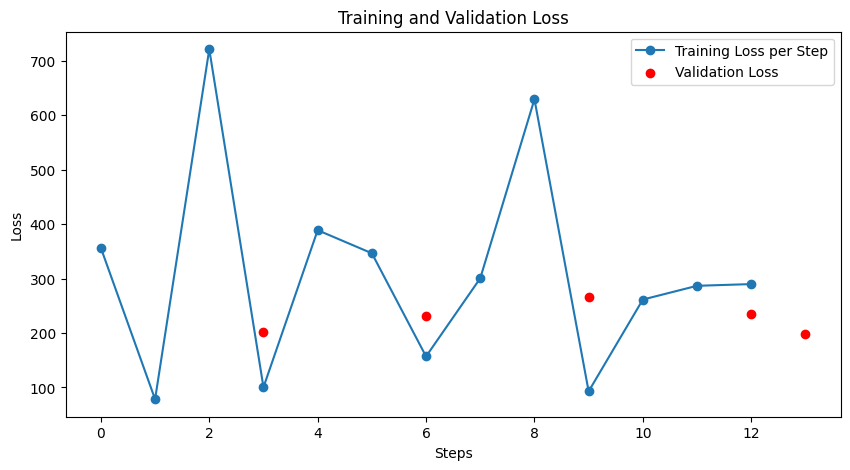

In [14]:
train_loop(model, train_loader, val_loader, optimizer, 1)

## Download Dataset from Historical Weather Data in Zurich

In [15]:
from datetime import datetime
from meteostat import Point, Daily

# Set time period
start = datetime(2000, 1, 1)
end = datetime(2024, 5, 31)

# Create a Point for Zurich
zurich = Point(47.200, 8.3300)

# Get daily data
data = Daily(zurich, start, end)
data = data.fetch()

# Print the data
print(data)


            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
time                                                                     
2005-09-14  18.0  16.0  21.0   NaN   NaN    NaN   3.5   NaN     NaN   NaN
2005-09-15   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN
2005-09-16   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN
2005-09-17   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN
2005-09-18   NaN   NaN   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN
...          ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2024-05-27  15.3  13.0  17.3  10.5   NaN  288.0   6.0  20.4  1019.0   NaN
2024-05-28  14.5  11.4  18.6   4.1   NaN  219.0   5.9  16.7  1020.8   NaN
2024-05-29  14.4  10.4  16.8   2.7   NaN  220.0   5.7  18.5  1016.5   NaN
2024-05-30  14.1  12.3  15.8  27.1   NaN  227.0   7.5  24.1  1009.8   NaN
2024-05-31  11.8  11.0  12.7   NaN   NaN  236.0   9.0  25.9  1013.2   NaN

[6835 rows x 10 columns]


## Clean Data and Create Training and Validation Dataset

The script prepares temperature data for training a sequence prediction model by:

- Selecting and cleaning the relevant data.
- Generating sequences and corresponding targets.
- Splitting the data into training and validation sets.
- Creating DataLoaders to feed the data into a model during training and validation.


In [16]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Keep only the 'tmax' (average temperature) column
data = data[['tmax']]

# Check for NaN values and handle them (e.g., drop them)
if data['tmax'].isna().sum() > 0:
    print(f"Found {data['tmax'].isna().sum()} NaN values in 'tmax' column. Dropping these rows.")
    data = data.dropna(subset=['tmax'])

# Convert the data to numpy array for sequence generation
temperatures = data['tmax'].values


# Function to create sequences and targets from the temperature data
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])  # Target is the temperature of the day after the sequence
    return np.array(sequences), np.array(targets)

# Adjust the length of the data to be a multiple of seq_length + 1
adjusted_length = (len(temperatures) // (seq_length + 1)) * (seq_length + 1)
temperatures = temperatures[:adjusted_length]

# Generate sequences and targets
seq_length = 30
sequences, targets = create_sequences(temperatures, seq_length)

# Convert to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

# Split into training and validation sets (80-20 split)
train_size = int(0.8 * len(sequences))
val_size = len(sequences) - train_size

# Ensure reproducibility
torch.manual_seed(42)
indices = torch.randperm(len(sequences))

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_sequences = sequences[train_indices]
train_targets = targets[train_indices]

val_sequences = sequences[val_indices]
val_targets = targets[val_indices]

# Create TensorDataset and DataLoader
train_data = TensorDataset(train_sequences, train_targets)
val_data = TensorDataset(val_sequences, val_targets)

train_loader = DataLoader(train_data, batch_size=30, shuffle=True)
val_loader = DataLoader(val_data, batch_size=30, shuffle=False)

Found 1768 NaN values in 'tmax' column. Dropping these rows.


In [17]:
print(train_data[5])

(tensor([21., 21., 14., 17., 18., 19., 21., 16., 19., 20., 24., 22., 25., 24.,
        16., 16., 18., 21., 23., 22., 24., 11., 11., 14., 18., 17., 21., -4.,
        -3., -3.,  2.,  0.]), tensor(7.))


## Train Model on Dataset

Epoch 1, Step 1/134, Training Loss: 69.10468292236328
Epoch 1, Step 2/134, Training Loss: 80.23005676269531
Epoch 1, Step 3/134, Training Loss: 84.26239013671875
Epoch 1, Step 4/134, Training Loss: 67.49596405029297
Epoch 1, Step 5/134, Training Loss: 52.188106536865234
Epoch 1, Step 6/134, Training Loss: 82.16775512695312
Epoch 1, Step 7/134, Training Loss: 70.95318603515625
Epoch 1, Step 8/134, Training Loss: 40.23377990722656
Epoch 1, Step 9/134, Training Loss: 58.4972038269043
Epoch 1, Step 10/134, Training Loss: 53.84492492675781
Epoch 1, Step 11/134, Training Loss: 72.38973236083984
Epoch 1, Step 12/134, Training Loss: 43.616554260253906
Epoch 1, Step 13/134, Training Loss: 32.32667541503906
Epoch 1, Step 14/134, Training Loss: 30.39213752746582
Epoch 1, Step 15/134, Training Loss: 35.837947845458984
Epoch 1, Step 16/134, Training Loss: 32.855613708496094
Epoch 1, Step 17/134, Training Loss: 22.3977108001709
Epoch 1, Step 18/134, Training Loss: 16.09404182434082
Epoch 1, Step 19/

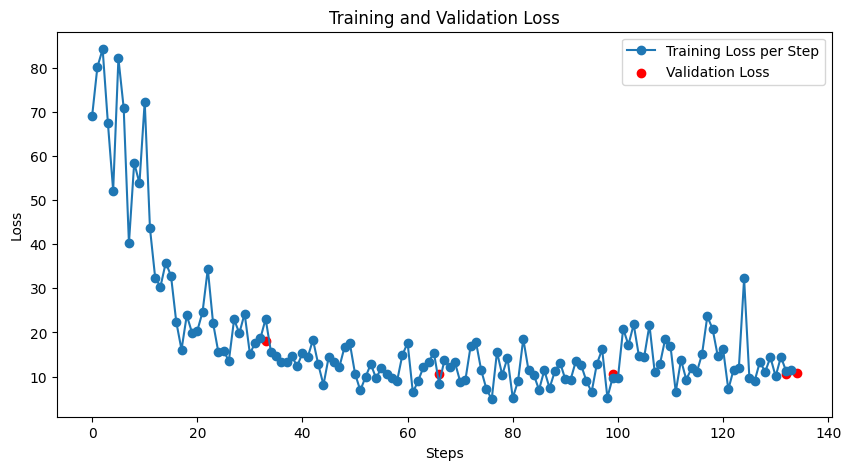

In [18]:
train_loop(model, train_loader, val_loader, optimizer, 1)

## Run a Forward Pass Recursively to Predict the Weather

This script fetches the most recent 30 days of maximum temperature data for Zurich, processes it into a format suitable for input into a predictive model, and uses the model to forecast the next 7 days of temperatures. The results include the actual temperatures for the last 7 days and the predicted temperatures for the upcoming 7 days, providing a comprehensive view of recent and anticipated weather trends.This script fetches the most recent 30 days of maximum temperature data for Zurich, processes it into a format suitable for input into a predictive model, and uses the model to forecast the next 7 days of temperatures. The results include the actual temperatures for the last 7 days and the predicted temperatures for the upcoming 7 days, providing a comprehensive view of recent and anticipated weather trends.

In [20]:
import torch
from datetime import datetime, timedelta
import pandas as pd
from meteostat import Point, Daily

# Set the location for Zurich
zurich = Point(47.200, 8.3300)

# Set the time period to fetch data
end = datetime.today()
start = end - timedelta(days=30)

# Get daily data
data = Daily(zurich, start, end)
data = data.fetch()

# Ensure there are no NaN values
data = data.dropna(subset=['tmax'])

# Get the last 30 days of temperature
last_30_days = data['tmax'].values[-30:]

# Convert to a PyTorch tensor
input_sequence = torch.tensor(last_30_days, dtype=torch.float32).cuda()

# Function to predict the next 7 days of temperature
def predict_next_7_days(model, input_sequence, days=7):
    model.eval()
    predictions = []

    for _ in range(days):
        with torch.no_grad():
            # Forward pass to get the next day's prediction
            output = model(input_sequence.unsqueeze(0).unsqueeze(-1))  # Ensure input is 3D
            next_day_temp = output.item()

            # Append the prediction to the list of predictions
            predictions.append(next_day_temp)

            # Update the input sequence by appending the predicted temperature and removing the oldest one
            input_sequence = torch.cat((input_sequence[1:], torch.tensor([next_day_temp], dtype=torch.float32).cuda()))

    return predictions

# Predict the next 7 days of temperature
predicted_temperatures = predict_next_7_days(model, input_sequence, days=7)

# Print the last 7 temperature data points
print("Last 7 days max temperatures:", [round(temp * 2) / 2 for temp in last_30_days[-7:]])

# Print the predictions
print("Predicted max temperatures for the next 7 days:", [round(temp * 2) / 2 for temp in predicted_temperatures])

Last 7 days max temperatures: [19.0, 21.5, 17.5, 18.5, 17.0, 16.0, 12.5]
Predicted max temperatures for the next 7 days: [15.0, 17.0, 18.5, 20.0, 21.5, 22.5, 23.0]
